# Exploratory NLP on chat messages in pilot data

## Import packages

In [1]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from collections import Counter
from num2words import num2words
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import matutils, models
import matplotlib.pyplot as plt

import nltk
import os
import string
import numpy as np
import copy
import pandas as pd
pd.set_option('display.max_colwidth', None)
import pickle
import re
import math


stemmer = SnowballStemmer("english")

## Import data frames (generated in DF_generator script from mongoDB)

In [4]:
df_chat = pd.read_csv('df_chat.csv')
print(df_chat.shape)
df_chat.head(2)

(3066, 21)


,Unnamed: 0,_id,iterationName,gameid,time,assignmentId,leftTarget,rightTarget,trialNum,turnNum,...,content,timeElapsedInTurn,timeElapsedInTrial,eventType,individualPracticeAttempts,turnStartTime,trialStartTime,practice,word_count,char_count
0,0,5ef78389ce2f7f58fcd0a350,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593279e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,vertical,horizontal,practice,0.0,...,place the red one 3 from the left and the blue 3 from the right,60567.0,60567.0,chatMessage,NaN,NaN,NaN,NaN,15,63
1,1,5ef783bace2f7f58fcd0a358,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593279e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,vertical,horizontal,practice,0.0,...,"close, but put the towers starting on the third blocks from each side\n",20018.0,20018.0,chatMessage,NaN,NaN,NaN,NaN,13,70


## Create Bag of Words for each repNum by concatenating content
create df with column for repnum and column for entire string grouped by repnum

In [5]:
df = df_chat[['repNum','content']]

df['BOW'] = df[['repNum','content']].groupby(['repNum'])['content'].transform(lambda x: ' '.join(x))
df = df[['repNum','BOW']]

df = df.drop_duplicates()
df.shape

/Users/choldawa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(5, 2)

In [6]:
df_chat.isnull().sum()

Unnamed: 0                      0
_id                             0
iterationName                   0
gameid                          0
time                            0
assignmentId                    0
leftTarget                      0
rightTarget                     0
trialNum                      112
turnNum                         0
repNum                          0
content                         0
timeElapsedInTurn               0
timeElapsedInTrial              0
eventType                       0
individualPracticeAttempts    938
turnStartTime                 980
trialStartTime                980
practice                      980
word_count                      0
char_count                      0
dtype: int64

In [7]:
df = df_chat[df_chat['trialNum'].notna()][['trialNum', 'content']]
df = df[df.trialNum != 'practice']
df['trialNum'] = pd.to_numeric(df['trialNum'])
df.head()

,trialNum,content
2,0.0,put a blue block three from the left~~~
3,0.0,place a red block on top of the left side of the blue block and then another red on top of that red
4,0.0,Now place a blue block on top of that that lines up with the bottom blue block
5,0.0,"remove that last blue block, place it on top of the red blocks"
6,0.0,place a red block on the second grid from the right of the screen\n


In [8]:
df['BOW'] = df[['trialNum','content']].groupby(['trialNum'])['content'].transform(lambda x: ' '.join(x))
df = df[['trialNum','BOW']]

df = df.drop_duplicates()
df.shape

(12, 2)

### Remove stopwords

In [51]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['BOW_clean'] = df['BOW'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [70]:
df['BOW_clean'] = df['BOW_clean'].str.lower()
df['BOW_clean'] = df['BOW_clean'].str.replace(r'~', '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r'\(', '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r'\)', '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r'\,', '')
df.head()

trialNum  \
2        0.0   
9        1.0   
15       2.0   
18       3.0   
20       4.0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

### Build a matrix of each word in the corpus and its TF-IDF for that comment

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = df['BOW_clean']
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()

dense = vectors.todense()
denselist = dense.tolist()
df_vectors = pd.DataFrame(denselist, columns=feature_names)


### Select the top 5 words (TF-IDF) for each comment
##### Intuitively, this roughly corresponds to what this person is talking about relatively more than any other person

In [72]:
Tops =pd.DataFrame(df_vectors.apply(lambda x:list(df_vectors.columns[np.array(x).argsort()[::-1][:15]]), axis=1).to_list())

Tops

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,red,block,blue,left,place,top,right,one,blocks,line,two,side,vertical,horizontal,2nd
1,red,block,blue,left,place,right,top,one,two,blocks,side,line,vertical,horizontal,put
2,red,blue,block,left,right,place,top,one,line,side,two,blocks,vertical,column,horizontal
3,red,blue,left,right,block,top,place,side,two,line,one,blocks,vertical,horizontal,column
4,red,left,blue,right,place,block,top,line,side,two,blocks,one,vertical,horizontal,shape
5,blue,red,left,right,place,block,top,line,side,one,two,blocks,vertical,shape,5th
6,left,blue,red,right,side,line,top,two,one,shape,place,block,blocks,3rd,2nd
7,red,left,blue,right,side,block,line,top,place,two,one,shape,2nd,square,row
8,left,blue,red,right,line,top,side,one,place,shape,two,square,block,2nd,3rd
9,left,red,blue,right,top,line,side,place,block,one,two,square,shape,2nd,row


## Okay, that was a dud, let's just lot histograms of word frequency for each repNum

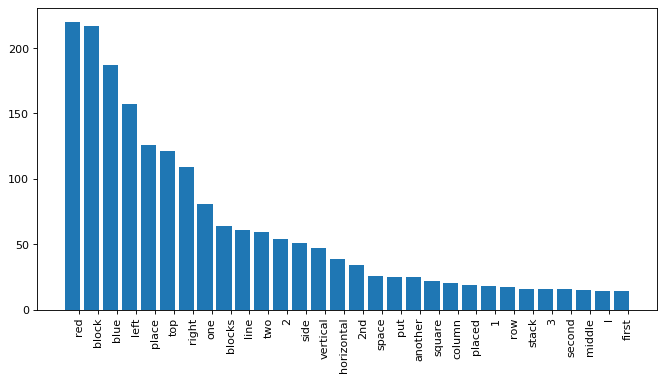

In [73]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')

from collections import Counter
x_limit = 30

word_list = df['BOW_clean'].iloc[0].split()

counts = Counter(word_list)

labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort][:x_limit]
values = np.array(values)[indSort][:x_limit]

indexes = np.arange(len(labels))

bar_width = 0.35

plt.bar(indexes, values)

# add labels
plt.xticks(indexes + bar_width, labels,  rotation='vertical')
plt.show()

In [74]:
total = sum(counts.values())

trial_0 = {k: v / total for k, v in counts.items()}

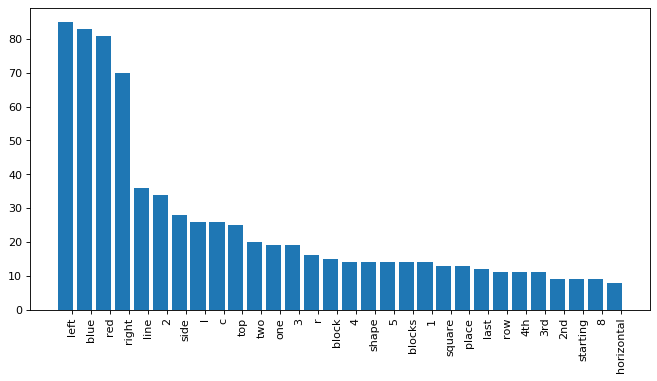

In [75]:
figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
x_limit = 30

word_list = df['BOW_clean'].iloc[11].split()

counts = Counter(word_list)

labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort][:x_limit]
values = np.array(values)[indSort][:x_limit]

indexes = np.arange(len(labels))

bar_width = 0.35

plt.bar(indexes, values)

# add labels
plt.xticks(indexes + bar_width, labels,  rotation='vertical')
plt.show()

In [76]:
total = sum(counts.values())

trial_11 = {k: v / total for k, v in counts.items()}

In [77]:
d_diff = {key: trial_11[key] - trial_0.get(key, 0) for key in trial_11}

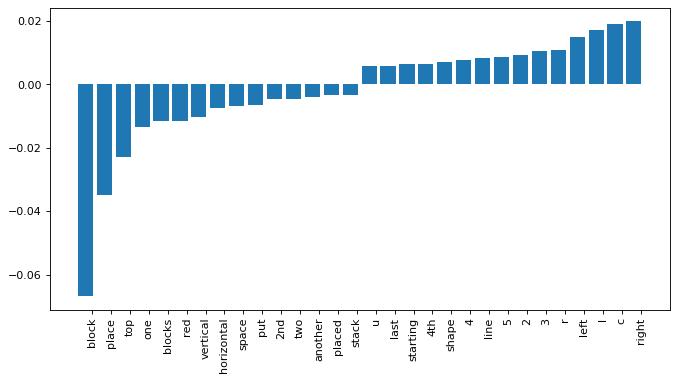

In [78]:
figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
x_limit = 15

labels, values = zip(*d_diff.items())

# sort your values in descending order
indSort_high = np.argsort(values)[::-1]
indSort_low = np.argsort(values)

# rearrange your data
#labels = np.array(labels)[indSort_high][:x_limit][::-1]
labels = np.concatenate([np.array(labels)[indSort_low][:x_limit],np.array(labels)[indSort_high][:x_limit][::-1]])
#values = np.array(values)[indSort_high][:x_limit][::-1]
values = np.concatenate([np.array(values)[indSort_low][:x_limit], np.array(values)[indSort_high][:x_limit][::-1]])

indexes = np.arange(len(labels))

bar_width = 0.35

plt.bar(indexes, values)

# add labels
plt.xticks(indexes + bar_width, labels,  rotation='vertical')
plt.show()

## WORD CLOUD!
perhaps pointless, but definitely fun!

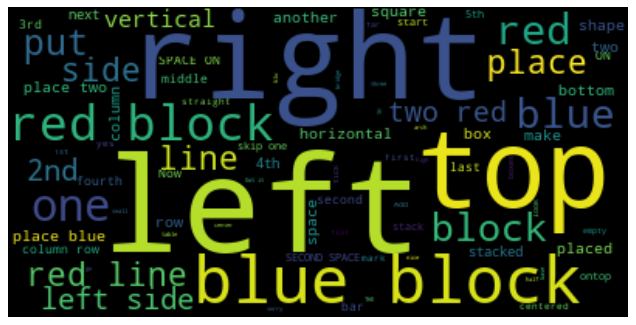

In [159]:
from wordcloud import WordCloud
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
wordcloud = WordCloud().generate(df['BOW_clean'].iloc[1])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
